## General

This colab notebook will generate image embeddings using EfficientNet, an image classification convolutional neural network pre-trained on ImageNet.

Image embeddings are generated by passing each image through the various 
layers of EfficientNet and taking the vector of numerical values from the 2nd last layer.

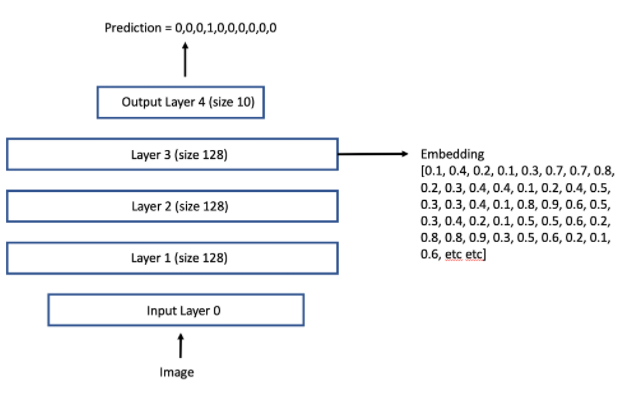

[Source: Chris Deotte](https://www.kaggle.com/c/shopee-product-matching/discussion/226279)

Default EfficientNetB4 as well as re-trained models will be used to generate image embeddings.

The next notebook 03_image_nearest_neighbours_cuml will use the Rapids cuML GPU machine learning library to predict the nearest neighbours of each image from the image embeddings.

In [ ]:
# Confirm GPU is running
!nvidia-smi

Thu Apr 22 03:14:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install EfficientNet
!pip install efficientnet

     |████████████████████████████████| 51kB 8.1MB/s 


In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import gc

from efficientnet.tfkeras import EfficientNetB4
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from PIL import Image

## Read Images from Google Drive

In [ ]:
# Copy Google Drive location of train images zip file
train_zip = 'file:///content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/train_images.zip'

In [ ]:
# Unzip using keras get_file function. fname parameter is redundant here.
train_zip_dir = tf.keras.utils.get_file(fname='-', origin=train_zip, extract=True)

1804738560/1804730397 [==============================] - 64s 0us/step


In [ ]:
# Create directory path to unzipped images
train_dir = os.path.join(os.path.dirname(train_zip_dir), 'train_images')
train_dir

'/root/.keras/datasets/train_images'

## Create Product Groupings

In [ ]:
# Open train dataset
train = pd.read_csv('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/train.csv')
train.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [ ]:
train.shape

(34250, 5)

In [ ]:
# Create dictionary of label groups (key) and posting IDs (values)
label_dict = train.groupby('label_group')['posting_id'].unique().to_dict()

# Create column of matching products
train['matches'] = train['label_group'].map(label_dict)
train.head()

,posting_id,image,image_phash,title,label_group,matches
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]"
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]"
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]"
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,"[train_2406599165, train_3342059966]"
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,"[train_3369186413, train_921438619]"


In [ ]:
# Create dictionary of image phash (key) and posting IDs (values)
label_dict = train.groupby('image_phash')['posting_id'].unique().to_dict()

# Create column of image duplicates
train['image_duplicates'] = train['image_phash'].map(label_dict)
train.head()

,posting_id,image,image_phash,title,label_group,matches,image_duplicates
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]",[train_129225211]
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]",[train_3386243561]
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]",[train_2288590299]
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,"[train_2406599165, train_3342059966]",[train_2406599165]
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,"[train_3369186413, train_921438619]",[train_3369186413]


In [ ]:
# Save train dataset as npy
np.save('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/train.npy', train.to_numpy())

## Image Embeddings with Default EfficientNetB4

### Generate Image Embeddings

In [ ]:
# Set image size for EfficientNetB4 input
im_size = 380

# Set batch size
batch = 32

# As the dataset is large, we will run the modelling in chunks
chunk_size = 5000
chunks = np.arange(np.ceil(len(train) / chunk_size))

# Set image paths of all images
image_paths = train_dir + '/' + train['image']

In [ ]:
# Create function to pre-process images
def process_image(image_file_path):
  
  # Read and decode image from file path
  image = tf.io.read_file(image_file_path)
  image = tf.image.decode_jpeg(image, channels = 3)

  # Resize image
  image = tf.image.resize(image, (im_size,im_size))

  # Scale image vector
  image = tf.cast(image, tf.float32) / 255.0
  return image

In [ ]:
# Create tensorflow dataset from image paths
def get_data(image_paths):
  dataset = tf.data.Dataset.from_tensor_slices(image_paths)

  # Process dataset with the image processing function created above. Set parallel calls to autotune
  dataset = dataset.map(process_image, num_parallel_calls = tf.data.AUTOTUNE)

  # Set batch size
  dataset = dataset.batch(batch_size = batch)

  # Set prefetch to autotune
  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  return dataset

In [ ]:
# Initialize EfficientNetB4 model pre-trained on ImageNet
B4_model = EfficientNetB4(weights='imagenet', include_top=False, pooling="avg")

In [ ]:
# Generate image embeddings from EfficientNetB4 model in chunks
# Initialize embeddings list
embeddings = []

# Iterate through chunks
for i in chunks:
  # Start and end index
  start = int(i * chunk_size)
  end = int((i + 1) * chunk_size)

  # Get image dataset
  image_dataset = get_data(image_paths[start:end])

  # Generate embeddings
  image_embeddings = B4_model.predict(image_dataset)

  # Append to embeddings list
  embeddings.append(image_embeddings)

  # Print status
  print(f'Chunk {i} completed')

train_image_embeddings = np.concatenate(embeddings)

# Delete temporary variables to free memory
del embeddings
del image_dataset
del image_embeddings

Chunk 0.0 completed
Chunk 1.0 completed
Chunk 2.0 completed
Chunk 3.0 completed
Chunk 4.0 completed
Chunk 5.0 completed
Chunk 6.0 completed


In [ ]:
# Check number of features from EfficientNetB4
train_image_embeddings.shape

(34250, 1792)

In [ ]:
# Save default embeddings as npy file
np.save('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/train_image_embeddings.npy', train_image_embeddings)

## Image Embeddings with Re-trained EfficientNetB4

Image embeddings could be improved by re-training EfficientNetB4 on the train dataset.

Default EfficientNetB4 was trained on ImageNet with 1000+ classes.

To re-train EfficientNetB4, we can add a final dense layer of 11,014 classes (based on the train dataset) and select the number of layers in EfficientNetB4 to retrain.

To generate image embeddings, we then remove the final dense layer to generate the embedding layer of 1792 features again.

In [ ]:
# Load train df
train = pd.DataFrame(np.load('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/train.npy', allow_pickle=True),
                     columns=['posting_id', 'image', 'image_phash', 'title', 'label_group', 'matches', 'image_duplicates'])

### Create Classes

In [ ]:
# Create classes for the 11014 unique label groups
label_groups = train['label_group'].unique()
label_groups_int = list(range(len(label_groups)))
label_groups_dict = dict(zip(label_groups,label_groups_int))
train['class'] = train['label_group'].map(label_groups_dict)
train.head()

,posting_id,image,image_phash,title,label_group,matches,image_duplicates,class
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]",[train_129225211],0
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]",[train_3386243561],1
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]",[train_2288590299],2
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,"[train_2406599165, train_3342059966]",[train_2406599165],3
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,"[train_3369186413, train_921438619]",[train_3369186413],4


### Create Dataset

In [ ]:
# Set number of classes
num_classes = 11014

# Set image size for EfficientNetB4 input
im_size = 380

# Set batch size
batch = 32

# As the dataset is large, we will run the modelling in chunks
chunk_size = 5000
chunks = np.arange(np.ceil(len(train) / chunk_size))

# Set image paths of all images
image_paths = train_dir + '/' + train['image']

In [ ]:
# Create function to pre-process images with labelled classes
def process_labelled_image(image_file_path, label):
  
  # Read and decode image from file path
  image = tf.io.read_file(image_file_path)
  image = tf.image.decode_jpeg(image, channels = 3)

  # Resize image
  image = tf.image.resize(image, (im_size,im_size))

  # Scale image vector
  image = tf.cast(image, tf.float32) / 255.0

  # One hot encode label
  label = tf.one_hot(label, num_classes)
  
  return image, label

In [ ]:
# Create tensorflow dataset from image paths with labels
def get_labelled_data(image_paths, labels):
  dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

  # Process dataset with the image processing function created above. Set parallel calls to autotune
  dataset = dataset.map(process_labelled_image, num_parallel_calls = tf.data.AUTOTUNE)

  # Set batch size
  dataset = dataset.batch(batch_size = batch)

  # Set prefetch to autotune
  dataset = dataset.prefetch(tf.data.AUTOTUNE)

  return dataset

In [ ]:
# Create train dataset
train_data = get_labelled_data(image_paths, train['class'].to_list())

### Create New Models

In [ ]:
# Initialize EfficientNetB4 model pre-trained on ImageNet
B4_model = EfficientNetB4(weights='imagenet', include_top=False, pooling="avg")

71892992/71892840 [==============================] - 1s 0us/step


In [ ]:
# Check default EfficientNetB4 layers
B4_model.summary()

Model: "efficientnet-b4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 4 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 4 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 4 0           stem_bn[0][0]                    
____________________________________________________________________________________

To generate new models, we can select which of the top layers in EfficientNetB4 to re-train, and for how many epochs.

#### Model 1

B4 -> Dense(11014)

B4 top layers trainable:
- top_conv

Batch = 32, Epochs = 3

In [ ]:
# Create new model for training
model_train = Sequential()

B4_model.trainable = True
for layer in B4_model.layers:
  layer.trainable = False
B4_model.layers[-4].trainable = True

model_train.add(B4_model)
model_train.add(Dense(11014, activation = 'softmax'))

model_train.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=["acc"],
)
model_train.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Functional) (None, 1792)              17673816  
_________________________________________________________________
dense_5 (Dense)              (None, 11014)             19748102  
Total params: 37,421,918
Trainable params: 20,550,918
Non-trainable params: 16,871,000
_________________________________________________________________


In [ ]:
history = model_train.fit(train_data,
                          batch_size = 32,
                          epochs = 3,)

Epoch 1/3
1071/1071 [==============================] - 456s 407ms/step - loss: 8.3078 - acc: 0.0840
Epoch 2/3
1071/1071 [==============================] - 440s 410ms/step - loss: 2.2056 - acc: 0.5394
Epoch 3/3
1071/1071 [==============================] - 440s 411ms/step - loss: 0.5923 - acc: 0.8623


In [ ]:
# Model for image embedding will be the retrained EfficientNet layer
model = Sequential(model_train.layers[0])

In [ ]:
model.save('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/models/model_1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/models/model_1/assets


#### Model 2

B4 -> Dense(11014)

B4 top layers trainable:
- block7b_project_conv
- top_conv

Batch = 32, Epochs = 3

In [ ]:
# Initialize EfficientNetB4 model pre-trained on ImageNet
B4_model = EfficientNetB4(weights='imagenet', include_top=False, pooling="avg")

# Create new model
model_2_train = Sequential()

# Train top EfficientNet layers
B4_model.trainable = True
for layer in B4_model.layers:
  layer.trainable = False
B4_model.layers[-8].trainable = True
B4_model.layers[-4].trainable = True

model_2_train.add(B4_model)
model_2_train.add(Dense(11014, activation = 'softmax'))
model_2_train.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=["acc"],
)
model_2_train.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Functional) (None, 1792)              17673816  
_________________________________________________________________
dense_6 (Dense)              (None, 11014)             19748102  
Total params: 37,421,918
Trainable params: 21,755,142
Non-trainable params: 15,666,776
_________________________________________________________________


In [ ]:
history_2 = model_2_train.fit(train_data,
                              batch_size = 32,
                              epochs = 3,)

Epoch 1/3
1071/1071 [==============================] - 453s 414ms/step - loss: 8.3803 - acc: 0.0751
Epoch 2/3
1071/1071 [==============================] - 448s 418ms/step - loss: 2.3799 - acc: 0.5069
Epoch 3/3
1071/1071 [==============================] - 448s 418ms/step - loss: 0.7019 - acc: 0.8350


In [ ]:
# Model for image embedding will be the retrained EfficientNet layer
model_2 = Sequential(model_2_train.layers[0])

In [ ]:
model_2.save('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/models/model_2')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/models/model_2/assets


#### Model 3

B4 -> Dense(11014)

B4 top layers trainable:
- block7b
- top_conv

BatchNormalization untrainable

Batch = 32, Epochs = 3

In [ ]:
# Train top layers from block 7b onwards, except BatchNormalization layers
for layer in B4_model.layers[-19:]:
  if 'bn' not in layer.name:
    print(layer.name)

block7b_expand_conv
block7b_expand_activation
block7b_dwconv
block7b_activation
block7b_se_squeeze
block7b_se_reshape
block7b_se_reduce
block7b_se_expand
block7b_se_excite
block7b_project_conv
block7b_drop
block7b_add
top_conv
top_activation
avg_pool


In [ ]:
# Initialize EfficientNetB4 model pre-trained on ImageNet
B4_model = EfficientNetB4(weights='imagenet', include_top=False, pooling="avg")

# Create new model
model_3_train = Sequential()

# Train top EfficientNet layers
B4_model.trainable = True
for layer in B4_model.layers[:-19]:
  layer.trainable = False
for layer in B4_model.layers[-19:]:
  if 'bn' in layer.name:
    layer.trainable = False

model_3_train.add(B4_model)
model_3_train.add(Dense(11014, activation = 'softmax'))
model_3_train.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=["acc"],
)
model_3_train.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Functional) (None, 1792)              17673816  
_________________________________________________________________
dense (Dense)                (None, 11014)             19748102  
Total params: 37,421,918
Trainable params: 23,588,470
Non-trainable params: 13,833,448
_________________________________________________________________


In [ ]:
history_3 = model_3_train.fit(train_data,
                              batch_size = 32,
                              epochs = 3,)

Epoch 1/3
1071/1071 [==============================] - 518s 443ms/step - loss: 8.3272 - acc: 0.0817
Epoch 2/3
1071/1071 [==============================] - 481s 449ms/step - loss: 2.2250 - acc: 0.5541
Epoch 3/3
1071/1071 [==============================] - 480s 448ms/step - loss: 0.5551 - acc: 0.8733


In [ ]:
# Model for image embedding will be the retrained EfficientNet layer
model_3 = Sequential(model_3_train.layers[0])

In [ ]:
model_3.save('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/models/model_3')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/models/model_3/assets


#### Model 4

B4 -> Dense(11014)

Retrain entire EfficientNetB4

Batch = 8, Epochs = 10

In [ ]:
# Initialize EfficientNetB4 model pre-trained on ImageNet
B4_model = EfficientNetB4(weights='imagenet', include_top=False, pooling="avg")

# Create new model
model_4_train = Sequential()

# Train all EfficientNet layers
B4_model.trainable = True

model_4_train.add(B4_model)
model_4_train.add(Dense(11014, activation = 'softmax'))
model_4_train.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=["acc"],
)

# Epochs trained at checkpoint: 8
model_4_train.load_weights('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/models/model_checkpoints')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/models/model_checkpoints',
    save_weights_only=True,
    monitor='acc',
    mode='max',
    save_best_only=True)

model_4_train.summary()

71892992/71892840 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Functional) (None, 1792)              17673816  
_________________________________________________________________
dense (Dense)                (None, 11014)             19748102  
Total params: 37,421,918
Trainable params: 37,296,718
Non-trainable params: 125,200
_________________________________________________________________


In [ ]:
# Train 2 more epochs from checkpoint
history_4 = model_4_train.fit(train_data,
                              batch_size = 8,
                              epochs = 2,
                              callbacks=[model_checkpoint_callback])

Epoch 1/2
4282/4282 [==============================] - 2514s 576ms/step - loss: 0.0824 - acc: 0.9820
Epoch 2/2
4282/4282 [==============================] - 2464s 575ms/step - loss: 0.0684 - acc: 0.9847


In [ ]:
# Model for image embedding will be the retrained EfficientNet layer
model_4 = Sequential(model_4_train.layers[0])

In [ ]:
model_4.save('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/models/model_4')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/models/model_4/assets


#### Model 5

B4 -> Dense(11014)

Retrain entire EfficientNetB4

Batch = 8, Epochs = 5

In [ ]:
# Initialize EfficientNetB4 model pre-trained on ImageNet
B4_model = EfficientNetB4(weights='imagenet', include_top=False, pooling="avg")

# Create new model
model_5_train = Sequential()

# Train all EfficientNet layers
B4_model.trainable = True

model_5_train.add(B4_model)
model_5_train.add(Dense(11014, activation = 'softmax'))
model_5_train.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=["acc"],
)
model_5_train.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Functional) (None, 1792)              17673816  
_________________________________________________________________
dense_3 (Dense)              (None, 11014)             19748102  
Total params: 37,421,918
Trainable params: 37,296,718
Non-trainable params: 125,200
_________________________________________________________________


In [ ]:
history_5 = model_5_train.fit(train_data,
                              batch_size = 8,
                              epochs = 5,)

Epoch 1/5
4282/4282 [==============================] - 2500s 580ms/step - loss: 9.3370 - acc: 0.0026
Epoch 2/5
4282/4282 [==============================] - 2487s 581ms/step - loss: 7.1098 - acc: 0.0239
Epoch 3/5
4282/4282 [==============================] - 2475s 578ms/step - loss: 3.8262 - acc: 0.2457
Epoch 4/5
4282/4282 [==============================] - 2480s 579ms/step - loss: 1.0980 - acc: 0.7528
Epoch 5/5
4282/4282 [==============================] - 2485s 580ms/step - loss: 0.3685 - acc: 0.9208


In [ ]:
# Model for image embedding will be the retrained EfficientNet layer
model_5 = Sequential(model_5_train.layers[0])

In [ ]:
model_5.save('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/models/model_5')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/models/model_5/assets


#### Model 6

B4 -> Dense(11014)

B4 top layers trainable:
- block7a
- block7b
- top_conv

BatchNormalization untrainable

Batch = 32, Epochs = 3

In [ ]:
B4_model = EfficientNetB4(weights='imagenet', include_top=False, pooling="avg")

71892992/71892840 [==============================] - 1s 0us/step


In [ ]:
# Train top layers from block 7a onwards, except BatchNormalization layers
for layer in B4_model.layers[-32:]:
  if 'bn' not in layer.name:
    print(layer.name)

block7a_expand_conv
block7a_expand_activation
block7a_dwconv
block7a_activation
block7a_se_squeeze
block7a_se_reshape
block7a_se_reduce
block7a_se_expand
block7a_se_excite
block7a_project_conv
block7b_expand_conv
block7b_expand_activation
block7b_dwconv
block7b_activation
block7b_se_squeeze
block7b_se_reshape
block7b_se_reduce
block7b_se_expand
block7b_se_excite
block7b_project_conv
block7b_drop
block7b_add
top_conv
top_activation
avg_pool


In [ ]:
# Initialize EfficientNetB4 model pre-trained on ImageNet
B4_model = EfficientNetB4(weights='imagenet', include_top=False, pooling="avg")

# Create new model
model_6_train = Sequential()

# Train top EfficientNet layers
B4_model.trainable = True
for layer in B4_model.layers[:-32]:
  layer.trainable = False
for layer in B4_model.layers[-32:]:
  if 'bn' in layer.name:
    layer.trainable = False

model_6_train.add(B4_model)
model_6_train.add(Dense(11014, activation = 'softmax'))
model_6_train.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=["acc"],
)
model_6_train.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Functional) (None, 1792)              17673816  
_________________________________________________________________
dense (Dense)                (None, 11014)             19748102  
Total params: 37,421,918
Trainable params: 25,001,850
Non-trainable params: 12,420,068
_________________________________________________________________


In [ ]:
history_6 = model_6_train.fit(train_data,
                              batch_size = 32,
                              epochs = 3,)

Epoch 1/3
1071/1071 [==============================] - 548s 470ms/step - loss: 8.5703 - acc: 0.0578
Epoch 2/3
1071/1071 [==============================] - 504s 470ms/step - loss: 2.4476 - acc: 0.5204
Epoch 3/3
1071/1071 [==============================] - 503s 469ms/step - loss: 0.6050 - acc: 0.8548


In [ ]:
# Model for image embedding will be the retrained EfficientNet layer
model_6 = Sequential(model_6_train.layers[0])

In [ ]:
model_6.save('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/models/model_6')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/models/model_6/assets


#### Model 7

B4 -> Dense(11014)

B4 top layers trainable:
- block7b
- top_conv

BatchNormalization untrainable

Batch = 32, Epochs = 6

In [ ]:
# Initialize EfficientNetB4 model pre-trained on ImageNet
B4_model = EfficientNetB4(weights='imagenet', include_top=False, pooling="avg")

# Create new model
model_7_train = Sequential()

# Train top EfficientNet layers
B4_model.trainable = True
for layer in B4_model.layers[:-19]:
  layer.trainable = False
for layer in B4_model.layers[-19:]:
  if 'bn' in layer.name:
    layer.trainable = False

model_7_train.add(B4_model)
model_7_train.add(Dense(11014, activation = 'softmax'))
model_7_train.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=["acc"],
)
model_7_train.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Functional) (None, 1792)              17673816  
_________________________________________________________________
dense_1 (Dense)              (None, 11014)             19748102  
Total params: 37,421,918
Trainable params: 23,588,470
Non-trainable params: 13,833,448
_________________________________________________________________


In [ ]:
history_7 = model_7_train.fit(train_data,
                              batch_size = 32,
                              epochs = 6,)

Epoch 1/6
1071/1071 [==============================] - 490s 448ms/step - loss: 8.3347 - acc: 0.0800
Epoch 2/6
1071/1071 [==============================] - 480s 448ms/step - loss: 2.2220 - acc: 0.5530
Epoch 3/6
1071/1071 [==============================] - 479s 447ms/step - loss: 0.5455 - acc: 0.8743
Epoch 4/6
1071/1071 [==============================] - 480s 448ms/step - loss: 0.3057 - acc: 0.9325
Epoch 5/6
1071/1071 [==============================] - 480s 448ms/step - loss: 0.2407 - acc: 0.9494
Epoch 6/6
1071/1071 [==============================] - 480s 448ms/step - loss: 0.1956 - acc: 0.9574


In [ ]:
# Model for image embedding will be the retrained EfficientNet layer
model_7 = Sequential(model_7_train.layers[0])

In [ ]:
model_7.save('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/models/model_7')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/models/model_7/assets


#### Model 8

B4 -> Dense(11014)

B4 top layers trainable:
- block7a
- block7b
- top_conv

BatchNormalization untrainable

Batch = 32, Epochs = 6

In [ ]:
# Initialize EfficientNetB4 model pre-trained on ImageNet
B4_model = EfficientNetB4(weights='imagenet', include_top=False, pooling="avg")

# Create new model
model_8_train = Sequential()

# Train top EfficientNet layers
B4_model.trainable = True
for layer in B4_model.layers[:-32]:
  layer.trainable = False
for layer in B4_model.layers[-32:]:
  if 'bn' in layer.name:
    layer.trainable = False

model_8_train.add(B4_model)
model_8_train.add(Dense(11014, activation = 'softmax'))
model_8_train.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=["acc"],
)
model_8_train.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Functional) (None, 1792)              17673816  
_________________________________________________________________
dense_2 (Dense)              (None, 11014)             19748102  
Total params: 37,421,918
Trainable params: 25,001,850
Non-trainable params: 12,420,068
_________________________________________________________________


In [ ]:
history_8 = model_8_train.fit(train_data,
                              batch_size = 32,
                              epochs = 6,)

Epoch 1/6
1071/1071 [==============================] - 516s 472ms/step - loss: 8.4830 - acc: 0.0648
Epoch 2/6
1071/1071 [==============================] - 506s 472ms/step - loss: 2.3188 - acc: 0.5328
Epoch 3/6
1071/1071 [==============================] - 505s 472ms/step - loss: 0.5898 - acc: 0.8572
Epoch 4/6
1071/1071 [==============================] - 504s 471ms/step - loss: 0.3654 - acc: 0.9108
Epoch 5/6
1071/1071 [==============================] - 505s 472ms/step - loss: 0.3297 - acc: 0.9216
Epoch 6/6
1071/1071 [==============================] - 502s 469ms/step - loss: 0.2663 - acc: 0.9361


In [ ]:
# Model for image embedding will be the retrained EfficientNet layer
model_8 = Sequential(model_8_train.layers[0])

In [ ]:
model_8.save('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/models/model_8')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/models/model_8/assets


### Generate Image Embeddings

#### Model 1

In [ ]:
# Generate image embeddings from model 1 in chunks
# Initialize embeddings list
embeddings = []

# Iterate through chunks
for i in chunks:
  # Start and end index
  start = int(i * chunk_size)
  end = int((i + 1) * chunk_size)

  # Get image dataset
  image_dataset = get_data(image_paths[start:end])

  # Generate embeddings
  image_embeddings = model.predict(image_dataset)

  # Append to embeddings list
  embeddings.append(image_embeddings)

  # Print status
  print(f'Chunk {i} completed')

train_image_embeddings_1 = np.concatenate(embeddings)
del embeddings
del image_dataset
del image_embeddings

Chunk 0.0 completed
Chunk 1.0 completed
Chunk 2.0 completed
Chunk 3.0 completed
Chunk 4.0 completed
Chunk 5.0 completed
Chunk 6.0 completed


In [ ]:
train_image_embeddings_1.shape

(34250, 1792)

In [ ]:
# Save embeddings as npy file
np.save('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/train_image_embeddings_1.npy', train_image_embeddings_1)

#### Model 2

In [ ]:
# Generate image embeddings from model 2 in chunks
# Initialize embeddings list
embeddings = []

# Iterate through chunks
for i in chunks:
  # Start and end index
  start = int(i * chunk_size)
  end = int((i + 1) * chunk_size)

  # Get image dataset
  image_dataset = get_data(image_paths[start:end])

  # Generate embeddings
  image_embeddings = model_2.predict(image_dataset)

  # Append to embeddings list
  embeddings.append(image_embeddings)

  # Print status
  print(f'Chunk {i} completed')

train_image_embeddings_2 = np.concatenate(embeddings)
del embeddings
del image_dataset
del image_embeddings

Chunk 0.0 completed
Chunk 1.0 completed
Chunk 2.0 completed
Chunk 3.0 completed
Chunk 4.0 completed
Chunk 5.0 completed
Chunk 6.0 completed


In [ ]:
train_image_embeddings_2.shape

(34250, 1792)

In [ ]:
# Save embeddings as npy file
np.save('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/train_image_embeddings_2.npy', train_image_embeddings_2)

#### Model 3

In [ ]:
# Generate image embeddings from model 3 in chunks
# Initialize embeddings list
embeddings = []

# Iterate through chunks
for i in chunks:
  # Start and end index
  start = int(i * chunk_size)
  end = int((i + 1) * chunk_size)

  # Get image dataset
  image_dataset = get_data(image_paths[start:end])

  # Generate embeddings
  image_embeddings = model_3.predict(image_dataset)

  # Append to embeddings list
  embeddings.append(image_embeddings)

  # Print status
  print(f'Chunk {i} completed')

train_image_embeddings_3 = np.concatenate(embeddings)
del embeddings
del image_dataset
del image_embeddings

Chunk 0.0 completed
Chunk 1.0 completed
Chunk 2.0 completed
Chunk 3.0 completed
Chunk 4.0 completed
Chunk 5.0 completed
Chunk 6.0 completed


In [ ]:
train_image_embeddings_3.shape

(34250, 1792)

In [ ]:
# Save embeddings as npy file
np.save('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/train_image_embeddings_3.npy', train_image_embeddings_3)

#### Model 4

In [ ]:
# Generate image embeddings from model 4 in chunks
# Initialize embeddings list
embeddings = []

# Iterate through chunks
for i in chunks:
  # Start and end index
  start = int(i * chunk_size)
  end = int((i + 1) * chunk_size)

  # Get image dataset
  image_dataset = get_data(image_paths[start:end])

  # Generate embeddings
  image_embeddings = model_4.predict(image_dataset)

  # Append to embeddings list
  embeddings.append(image_embeddings)

  # Print status
  print(f'Chunk {i} completed')

train_image_embeddings_4 = np.concatenate(embeddings)
del embeddings
del image_dataset
del image_embeddings

Chunk 0.0 completed
Chunk 1.0 completed
Chunk 2.0 completed
Chunk 3.0 completed
Chunk 4.0 completed
Chunk 5.0 completed
Chunk 6.0 completed


In [ ]:
train_image_embeddings_4.shape

(34250, 1792)

In [ ]:
# Save embeddings as npy file
np.save('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/train_image_embeddings_4.npy', train_image_embeddings_4)

#### Model 5

In [ ]:
# Generate image embeddings from model 5 in chunks
# Initialize embeddings list
embeddings = []

# Iterate through chunks
for i in chunks:
  # Start and end index
  start = int(i * chunk_size)
  end = int((i + 1) * chunk_size)

  # Get image dataset
  image_dataset = get_data(image_paths[start:end])

  # Generate embeddings
  image_embeddings = model_5.predict(image_dataset)

  # Append to embeddings list
  embeddings.append(image_embeddings)

  # Print status
  print(f'Chunk {i} completed')

train_image_embeddings_5 = np.concatenate(embeddings)
del embeddings
del image_dataset
del image_embeddings

Chunk 0.0 completed
Chunk 1.0 completed
Chunk 2.0 completed
Chunk 3.0 completed
Chunk 4.0 completed
Chunk 5.0 completed
Chunk 6.0 completed


In [ ]:
train_image_embeddings_5.shape

(34250, 1792)

In [ ]:
# Save embeddings as npy file
np.save('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/train_image_embeddings_5.npy', train_image_embeddings_5)

#### Model 6

In [ ]:
# Generate image embeddings from model 6 in chunks
# Initialize embeddings list
embeddings = []

# Iterate through chunks
for i in chunks:
  # Start and end index
  start = int(i * chunk_size)
  end = int((i + 1) * chunk_size)

  # Get image dataset
  image_dataset = get_data(image_paths[start:end])

  # Generate embeddings
  image_embeddings = model_6.predict(image_dataset)

  # Append to embeddings list
  embeddings.append(image_embeddings)

  # Print status
  print(f'Chunk {i} completed')

train_image_embeddings_6 = np.concatenate(embeddings)
del embeddings
del image_dataset
del image_embeddings

Chunk 0.0 completed
Chunk 1.0 completed
Chunk 2.0 completed
Chunk 3.0 completed
Chunk 4.0 completed
Chunk 5.0 completed
Chunk 6.0 completed


In [ ]:
train_image_embeddings_6.shape

(34250, 1792)

In [ ]:
# Save embeddings as npy file
np.save('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/train_image_embeddings_6.npy', train_image_embeddings_6)

#### Model 7

In [ ]:
# Generate image embeddings from model 7 in chunks
# Initialize embeddings list
embeddings = []

# Iterate through chunks
for i in chunks:
  # Start and end index
  start = int(i * chunk_size)
  end = int((i + 1) * chunk_size)

  # Get image dataset
  image_dataset = get_data(image_paths[start:end])

  # Generate embeddings
  image_embeddings = model_7.predict(image_dataset)

  # Append to embeddings list
  embeddings.append(image_embeddings)

  # Print status
  print(f'Chunk {i} completed')

train_image_embeddings_7 = np.concatenate(embeddings)
del embeddings
del image_dataset
del image_embeddings

Chunk 0.0 completed
Chunk 1.0 completed
Chunk 2.0 completed
Chunk 3.0 completed
Chunk 4.0 completed
Chunk 5.0 completed
Chunk 6.0 completed


In [ ]:
train_image_embeddings_7.shape

(34250, 1792)

In [ ]:
# Save embeddings as npy file
np.save('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/train_image_embeddings_7.npy', train_image_embeddings_7)

#### Model 8

In [ ]:
# Generate image embeddings from model 8 in chunks
# Initialize embeddings list
embeddings = []

# Iterate through chunks
for i in chunks:
  # Start and end index
  start = int(i * chunk_size)
  end = int((i + 1) * chunk_size)

  # Get image dataset
  image_dataset = get_data(image_paths[start:end])

  # Generate embeddings
  image_embeddings = model_8.predict(image_dataset)

  # Append to embeddings list
  embeddings.append(image_embeddings)

  # Print status
  print(f'Chunk {i} completed')

train_image_embeddings_8 = np.concatenate(embeddings)
del embeddings
del image_dataset
del image_embeddings

Chunk 0.0 completed
Chunk 1.0 completed
Chunk 2.0 completed
Chunk 3.0 completed
Chunk 4.0 completed
Chunk 5.0 completed
Chunk 6.0 completed


In [ ]:
train_image_embeddings_8.shape

(34250, 1792)

In [ ]:
# Save embeddings as npy file
np.save('/content/drive/MyDrive/General Assembly - Data Science Immersive/shopee-product-matching/datasets/train_image_embeddings_8.npy', train_image_embeddings_8)

Image embeddings generated in this notebook will be scored in notebook 03_nearest_neighbours_cuml using the RAPIDS cuML.NearestNeighbors algorithm.